# My summary

## Image classification using deep learning

The most important step in solving any real-world problem is to get the data. Kaggle provides a huge number of competitions on different data science problems.

The dogscats dataset contains 25,000 images of dogs and cats. Preprocessing of data and the creation of train, validation, and test splits are some of the important steps that need to be performed before we can implement an algorithm.

Most of the frameworks make it easier to read the images and tag them to their labels when provided in the following format. That means that each class should have a separate folder of its images. Here, all cat images should be in the `cat` folder and dog images in the `dog` folder.

Python makes it easy to put the data into the right format. Let's quickly take a look at the code and, then, we will go through the important parts of it.

In [1]:
from glob import glob
import numpy as np
import os

import torch

In [2]:
path = 'data/mydogsandcats/'
original_images_path = 'data/dogsandcats/'

# Read all the file inside our folder
files = glob(original_images_path + '*.jpg')

print(f"Total no. of images {len(files)}")

no_of_images = len(files)

# Create a shuffled index which cam be used to create a validation
# data set
shuffle = np.random.permutation(no_of_images)

# Create directories with label names
for t in ['train/', 'valid/']:
    # Create a train and validation folders
    os.mkdir(path + t)
    for folder in ['dog/', 'cat/']:
        os.mkdir(path + t + folder)

# Copy a small subset of images into validation folder
for i in shuffle[:2000]:
    folder = files[i].split('/')[-1].split('.')[0]
    image = files[i].split('/')[-1]
    os.rename(files[i], os.path.join(path, 'valid', folder, image))

# Copy a small subset of images into training folder
for i in shuffle[2000:]:
    folder = files[i].split('/')[-1].split('.')[0]
    image = files[i].split('/')[-1]
    os.rename(files[i], os.path.join(path, 'train', folder, image))

Total no. of images 0


FileExistsError: [Errno 17] File exists: 'data/mydogsandcats/train/'

All the preceding code does is retrieve all the files and pick 2,000 images for creating a validation set. It segregates all the images into the two categories of cats and dogs. It is a common and important practice to create a separate validation set, as it is not fair to test our algorithms on the same data it is trained on. To create a `validation` dataset, we create a list of numbers that are in the range of the length of the images in a shuffled order. The shuffled numbers act as an index for us to pick a bunch of images for creating our `validation` dataset. Let's go through each section of the code in detail.

### Loading data into PyTorch tensors

The PyTorch `torchvision.datasets` package provides a utility class called `ImageFolder` that can be used to load images along with their associated labels when data is presented in the aforementioned format. It is a common practice to perform the following preprocessing steps:

1. Resize all the images to the same size. Most of the deep learning architectures expect the images to be of the same size.
2. Normalize the dataset with the mean and standard deviation of the dataset.
3. Convert the image dataset to a PyTorch tensor.

PyTorch makes a lot of these preprocessing steps easier by providing a lot of utility functions in the `transforms` module. For our example, let's apply three transformations:
- Scale to a 256 x 256 image size
- Convert to a PyTorch tensor
- Normalize the data

The following code demonstrates how transformation can be applied and images are loaded using the `ImageFolder` class:

In [4]:
from torchvision import datasets, transforms
path = 'data/mydogsandcats/'

In [5]:
simple_transform = transforms.Compose([
        transforms.ToTensor(), transforms.Normalize(
                [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
train = datasets.ImageFolder(path + 'train/', simple_transform)
valid = datasets.ImageFolder(path + 'valid/', simple_transform)

The `train`object holds all the images and associated labels for the dataset. It contains two important attributes: one that gives a mapping between classes and the associated index used in the dataset and another one that gives a list of classes:
- `train.class_to_idx - {'cat': 0, 'dog': 1}`
- `train.classes - ['cat', 'dog']`

In [6]:
print(train.classes)
print(valid.classes)

['cat', 'dog']
['cat', 'dog']


It is often a best practice to visualize the data loaded into tensors. To visualize the tensors, we have to reshape the tensors and denormalize the values. The following function does that for us:

In [7]:
import matplotlib.pyplot as plt

In [8]:
def imshow(inp):
    """Imshow for Tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np. array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

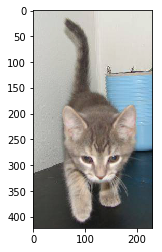

In [9]:
imshow(train[50][0])

### Loading PyTorch tensors as batches

It is a common practice in deep learning or machine learning to batch samples of images, as modern graphics processing units (GPUs) and CPUs are optimized to run operations faster on a batch of images. The batch size generally varies depending on the kind of GPU we use. Each GPU has its own memory, which can vary from 2 GB to 12 GB, and sometimes more for commercial GPUs. PyTorch provides the `DataLoader` class, which takes in a dataset and returns us a batch of images. It abstracts a lot of complexities in batching, such as the usage of multi-workers for applying transformation. The following code converts the previous `train` and `valid` datasets into data loaders:

In [10]:
from torch.utils.data import DataLoader

In [11]:
train_data_gen = DataLoader(train, batch_size=2, num_workers=3)
valid_data_gen = DataLoader(valid, batch_size=2, num_workers=3)

The `DataLoader` class provides us with a lot of options and some of the most commonly used ones are as follows:
- `shuffle`: When true, this shuffles the images every time the data loader is called.
- `num_workers`: This is responsible for parallelization. It is common practice to use a number of workers fewer than the number of cores available in your machine.

### Building the network architecture

For most of the real-world use cases, particularly in computer vision, we rarely build our own architecture. There are different architectures that can be quickly used to solve our real-world problems. For our example, we use a popular deep learning algorithm called ResNet, which won the first prize in 2015 in different competitions, such as ImageNet, related to computer vision.

PyTorch makes it easier to use a lot of these popular algorithms by providing them off the shelf in the `torchvision.models` module. So, for this example, let's quickly take a look at how to use this algorithm and then walk through each line of code:

In [12]:
from torch import nn
from torchvision import models

In [13]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

If you are running this algorithm on a GPU-based machine, then to make the algorithm run on a GPU we call the `cuda` method on the model. It is strongly recommended that you run these programs on a GPU-powered machine; it is easy to spin a cloud instance with a GPU for less than a dollar. The last line in the following code snippet tells PyTorch to run the code on the GPU:

In [14]:
from torch import cuda
if cuda.is_available():
    model_ft = model_ft.cuda()

The `models.resnet18(pretrained=True)` object creates an instance of the algorithm, which is a collection of PyTorch layers. We can take a quick look at what constitutes the ResNet algorithm by printing `model_ft`. A small portion of the algorithm looks like the following screenshot.

In [15]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

As we can see, the ResNet architecture is a collection of layers, namely `Conv2d`, `BatchNorm2d`, and `MaxPool2d`, stitched in a particular way. All these algorithms will accept an argument called pretrained. When `pretrained` is `True`, the weights of the algorithm are already tuned for a particular ImageNet classification problem of predicting 1,000 different categories, which include cars, ships, fish, cats, and dogs. This algorithm is trained to predict the 1,000 ImageNet categories and the weights are adjusted to a certain point where the algorithm achieves state-of-art accuracy. These weights are stored and shared with the model that we are using for the use case. Algorithms tend to work better when started with fine-tuned weights, rather than when started with random weights. So, for our use case, we start with pretrained weights.

The ResNet algorithm cannot be used directly, as it is trained to predict one of the 1,000 categories. For our use case, we need to predict only one of the two categories of dogs and cats. To achieve this, we take the last layer of the ResNet model, which is a `linear` layer and change the output features to two, as shown in the following code: `model_ft.fc = nn.Linear(num_ftrs, 2)`

### Training the model

Now, let's train the model. To do this we need a `loss` function and an `optimizer`:

In [29]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

torch.manual_seed(1)

# device = torch.device("cuda" if use_cuda else "cpu")
device = torch.device("cuda" if False else "cpu")
batch_size = 1
lr = 0.001
momentum = 0.9
epochs = 1
log_interval = 2
save_model = True

# kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
kwargs = {}

# Transforms
simple_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

# Dataset
train_dataset = datasets.ImageFolder(path + 'train/', simple_transform)
valid_dataset = datasets.ImageFolder(path + 'valid/', simple_transform)

# Data loader
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=4)

test_loader = torch.utils.data.DataLoader(
    dataset=valid_dataset, batch_size=batch_size, shuffle=False,
    num_workers=4)

# Convolutional neural network (ResNet18)
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)
optimizer = optim.SGD(
    model.parameters(), lr=lr, momentum=momentum)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

if (save_model):
    torch.save(model.state_dict(), "cnn.pt")


Train Epoch: 1 [0/17155 (0%)]	Loss: 0.395967
Train Epoch: 1 [2/17155 (0%)]	Loss: 1.055559
Train Epoch: 1 [4/17155 (0%)]	Loss: 1.016347
Train Epoch: 1 [6/17155 (0%)]	Loss: 0.934866
Train Epoch: 1 [8/17155 (0%)]	Loss: 0.748636
Train Epoch: 1 [10/17155 (0%)]	Loss: 1.359578
Train Epoch: 1 [12/17155 (0%)]	Loss: 0.913569
Train Epoch: 1 [14/17155 (0%)]	Loss: 2.093839
Train Epoch: 1 [16/17155 (0%)]	Loss: 2.766757
Train Epoch: 1 [18/17155 (0%)]	Loss: 0.120045
Train Epoch: 1 [20/17155 (0%)]	Loss: 0.318682
Train Epoch: 1 [22/17155 (0%)]	Loss: 0.596024
Train Epoch: 1 [24/17155 (0%)]	Loss: 1.332160
Train Epoch: 1 [26/17155 (0%)]	Loss: 1.352974
Train Epoch: 1 [28/17155 (0%)]	Loss: 0.517876
Train Epoch: 1 [30/17155 (0%)]	Loss: 0.280251
Train Epoch: 1 [32/17155 (0%)]	Loss: 1.831676
Train Epoch: 1 [34/17155 (0%)]	Loss: 0.453504
Train Epoch: 1 [36/17155 (0%)]	Loss: 2.796932
Train Epoch: 1 [38/17155 (0%)]	Loss: 2.435313
Train Epoch: 1 [40/17155 (0%)]	Loss: 0.668573


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ernesto/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/ernesto/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ernesto/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/ernesto/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/ernesto/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/ernesto/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ernesto/anaconda3/lib/python3.7/multiprocessing/connectio

KeyboardInterrupt: 